## 2019MCB1213 Ashish Sharma CS517 Project

## Note: The images along with ipynb file can be found in zip folder submitted as well
- I have submitted zip folder containing 4 images along with ipynb file
- And this separate ipynb file

## Instruction :
- The code was written in Jupyter Notebook
- When seeing results in **Google Colab**, kindly scroll through the results. In Jupyter Notebook all are displayed without scrolling but in colab scrolling is needed

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

## Step 1: Dividing Image into Non - Overlapping Parts

In [2]:
def get_scene_maps(im, k = 15, g1 = 120, g2 = 160):
  """
  This function takes input arguments as :
  1) im: the input image loaded in a numpy array using mathplotlib.pyplot.imread
  2) k : the number of scenes in the image
  3) g1: number of slices along the x axis grid of the image
  4) g2: number of slices along the y axis of the image
  g1 and g2 divide the image into disjoint patches
  The function returns:
  1) C: The correspondance of each pixel with its scene
  2) V_mat: The correspondance of each pixel with the value of {mean - standard deviation} for that sub-division 
            of the image. The sub-divisions being formed by g1 and g2
  """
  #Initializing Variables
  l = im.shape[0] * im.shape[1]          
  C = np.zeros((im.shape[0], im.shape[1]))
  V_mat = np.zeros((im.shape[0], im.shape[1]))
  
  #Finding End points of grid
  row_ends = np.linspace(0, im.shape[0], g1+1)
  col_ends = np.linspace(0, im.shape[1], g2+1)
  row_ends = np.array(row_ends, dtype = np.int64)
  col_ends = np.array(col_ends, dtype = np.int64)  
  
  #Evaluating Mean - Standard Deviation for each sub-division of grid
  for i in range(len(row_ends)-1):
    for j in range(len(col_ends)-1):
      img_part_mean = None
      img_part_std = None
      try:
        img_part_mean = np.mean(im[row_ends[i]:row_ends[i+1], col_ends[j]:col_ends[j+1]])
      except:
        img_part_mean = 0
      img_part_std  = np.std(im[row_ends[i]:row_ends[i+1], col_ends[j]:col_ends[j+1]])
      V_mat[row_ends[i]:row_ends[i+1],col_ends[j]:col_ends[j+1]] = img_part_mean - img_part_std      
  
  #Flattening Out the Mean - standard deviation value matrix
  V_mat2 = V_mat.copy()
  V_sort = V_mat2.ravel()
  V_sort.sort()
  
  #Using the given algorithm for Scene Segmentation from Section 3.1
  for x in range(im.shape[0]):
    for y in range(im.shape[1]):
      for i in range(1, k+1):
        condition1 = (V_mat[x, y] >= V_sort[max(int((i-1)/k * l), 1)-1])
        condition2 = V_sort[int(i/k * l)-1] >= V_mat[x, y]
        if condition1 and condition2:
          C[x][y] = i
          break
  return C, V_mat

## Step 2: Rough Estimate of Scene Luminance

In [3]:
def get_scene_luminance(im, C, et = 5, k = 15):
  """
  This function takes in:
  1) im: The original image
  2) C:  The Scene Mappings of pixels
  3) et: The erosion window size
  4) k: The number of scenes
  Returns:
  1) luminance_maps: Luminance maps for each color channel and
  2) L: Luminance dictionary containing luminance value for each scene and channel
  """
  #Initializing Variables
  l = im.shape[0] * im.shape[1]
  erosion_template = np.ones((et, et))
  eroded_channels = []
  
  #Performing Erosion on Each Color Channel
  for channel in range(3):
    eroded_channels.append(cv2.erode(im[:, :, channel], erosion_template))
  eroded_channels = np.array(eroded_channels)  
  
  #Initializing Luminance Map List, one map for each channel
  luminance_maps = [np.zeros((im.shape[0], im.shape[1])) for i in range(3)]
  luminance_maps = np.array(luminance_maps)
  L = {channel : {scene: None for scene in range(k)} for channel in range(3)}
  
  #Solving for Luminance Maps, choosing top 0.1 percent pixels from each scene for each channel
  # and taking their mean
  for scene in range(1, k+1):
    for channel in range(3):
      scene_channel_copy = eroded_channels[channel][C == scene].copy()
      scene_channel_copy = np.array(scene_channel_copy)  
      scene_channel_copy[::-1].sort()
      scene_channel_luminance = 0
      if len(scene_channel_copy):        
        scene_channel_luminance = np.mean(scene_channel_copy[0:len(scene_channel_copy)//10 + 1])      
      luminance_maps[channel][C == scene] = int(scene_channel_luminance)
      L[channel][scene] = scene_channel_luminance  
  
  return luminance_maps, L

## Step 3: The rough estimate of Scene Transmission

In [4]:
def getSobel(im):
  """
  This function takes input:
  1) im: The image
  and Returns:
  1) netSobel: the output after combining the Sobel output from x and y direction
  This  function is used for gradient estimation
  """
  scale = 1
  delta = 0
  ddepth = cv2.CV_16S
  sobelX = cv2.Sobel(im, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
  sobelY = cv2.Sobel(im, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
  absSobelx = cv2.convertScaleAbs(sobelX)
  absSobely = cv2.convertScaleAbs(sobelY)
  netSobel = cv2.addWeighted(absSobelx, 0.5, absSobely, 0.5, 0)
  return netSobel

In [5]:
def get_scene_transmission(im, V_mat, C, L, k = 15):
  """
  This function takes input:
  1) im: The original Image
  2) V_mat: the matrix containing corresponding mean - standard deviation values of its scene for each pixel
  3) C: The mappings of each pixel to its scene
  4) L: the dictionary containing luminance values for each scene and channel
  5) k: the number of scenes
  and returns:
  1) scene_transmission: mapping of each pixel to its corresponding transmission value
  2) T_tilda: dictionary mapping scene number to scene transmission value
  """  
  #initializing variables
  l = im.shape[0] * im.shape[1]
  T_cap = {i:0 for i in range(1, k+1)}
  T_i = 0.1
  channel_grads = []
  
  #finding individual channel gradient approximations using sobel kernels
  channel_grads.append(getSobel(im[:, :, 0]))
  channel_grads.append(getSobel(im[:, :, 1]))
  channel_grads.append(getSobel(im[:, :, 2]))
  channel_grads = np.array(channel_grads)  
  
  #finding transmission for each scene by iterating over all possible values of T_i between 0 and 0.1
  #1000 slices of the interval were made
  for scene in range(1, k + 1):
    T_i_cap = None
    summation = 1e9
    for T_i in np.linspace(0.1, 1, 1000, endpoint=True):
      temp = 0
      for channel in range(3):
        temp += -1 * np.sum(channel_grads[channel][C == scene])/(L[channel][scene] * T_i)
      if temp < summation:
        T_i_cap = T_i
        summation = temp
    T_cap[scene] = T_i_cap  
    
    chi = {i:0 for i in range(1, k+1)}
      
  #Calculating average of all haze density values in every scene followed by normalization
  scaler = 0
  for scene in range(1, k + 1):
    try:
      chi[scene] = np.mean(V_mat[C == scene])
    except:
      chi[scene] = 0
    scaler = max(scaler, chi[scene])
  for scene in range(1, k+1):
    chi[scene] /= scaler   
    
  Mi = {i:0 for i in range(1, k+1)}
  
  T_tilda = {i:0 for i in range(1, k+1)}
  
  #Finding adjusted scene transmissions after product with Mi_i
  w = 0.15
  for i in range(1, k + 1):  
    Mi[i] = 2 - np.exp(-1 * (chi[i] - 0.5)**2/(2 * w * w))
    T_tilda[i] = T_cap[i] * Mi[i]  
    
  scene_transmission = np.zeros((im.shape[0], im.shape[1]))
  
  for scene in range(1, k+1):
    scene_transmission[C == scene] = T_tilda[scene]  
    
  return scene_transmission, T_tilda

## Step 4:Edge Optimization Based on Guided Total Variation Model

In [6]:
def refine_transmission_luminance(luminance_maps, C, im, T_tilda, alpha = 3, beta = 0, gamma = 4, r = None, max_iterations = int(1e8), eps = 1e-3, eps2 = 0.1):
  """
  This function takes in :
  1) Luminance maps
  2) C: the pixel correspondance with scene
  3) im: the original image
  4) T_tilda: the transmission map dictionary
  5) alpha, beta, gamma as parameters involved in equations
  6) r: size of neighborhood
  7) max_iterations: max number of iterations to stop after
  8) eps : threshold for breaking out of transmission refinement loop
  9) eps2: thresholf for breaking out of luminance refinement loop
  """
  l = im.shape[0] * im.shape[1]
  r =max(im.shape[0:2])//15
  
  im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  im_gray_grad = getSobel(im_gray)
  W = 1 - np.exp(-1 * np.abs(im_gray_grad))

  T_tilda_mat = np.zeros(im.shape[0:2])  
  for x in range(im.shape[0]):
    for y in range(im.shape[1]):
      T_tilda_mat[x, y] = T_tilda[C[x, y]]  
  
  #Making kernels to efficiently subtract neigbors from center pixel
  r_kernel = np.zeros((r, r)) - 1
  r_kernel[r_kernel.shape[0]//2, r_kernel.shape[1]//2] = r**2 - 1

  ri_kernel = np.zeros((r, r)) + 1
  ri_kernel[ri_kernel.shape[0]//2, ri_kernel.shape[1]//2] = 0    
  
  T_iter_refine = T_tilda_mat.copy()
  T_iter_refine = np.array(T_iter_refine, dtype = np.float64)
  
  ddepth = cv2.CV_16S # not used
  # Refinement of transmission map according to equation in paper
  for iteration in range(max_iterations):  
    beta = 3 * (iteration - 1)
    old = T_iter_refine.copy()  
    T_iter_refine = (alpha * T_tilda_mat + gamma * W * cv2.filter2D(im_gray_grad,-1, r_kernel) + (W * (gamma - beta) + beta) * cv2.filter2D(old,-1 , ri_kernel))/(alpha + (r**2 - 1) * (W * (gamma - beta) + beta))
    change = ((np.linalg.norm(T_iter_refine-old, ord = 2)**2)/l)
    if change <= eps:
      break  
      
  luminance_maps_refine = luminance_maps.copy()
  
  # Refinement of luminance map according to equation in paper
  for map_num in range(3):
    for iteration in range(max_iterations):  
      beta = 3 * (iteration - 1)
      old = luminance_maps_refine[map_num].copy()  
      luminance_maps_refine[map_num] = (alpha * luminance_maps[map_num] + gamma * W * cv2.filter2D(im_gray_grad,-1, r_kernel) + (W * (gamma - beta) + beta) * cv2.filter2D(old,-1 , ri_kernel))/(alpha + (r**2 - 1) * (W * (gamma - beta) + beta))
      change = ((np.linalg.norm(luminance_maps_refine[map_num]-old, ord = 2)**2)/l)
      if change <= eps2:
        break    
  return T_iter_refine, luminance_maps_refine, im_gray_grad

## Step 5: Image Restoration

In [7]:
def get_restored_img(im, T_iter_refine, luminance_maps_refine):
  """
  Returns the restored image after performing restoration operation followed by bounding using max and min
  """
  l = im.shape[0] * im.shape[1]
  restored = np.zeros(im.shape, dtype = np.float64)
  for channel in range(3):
    restored[:, :, channel] = 1 + (im[:, :, channel] - luminance_maps_refine[channel])/(luminance_maps_refine[channel] * T_iter_refine)  
  
  Restored = np.zeros(im.shape, dtype = np.float64)
  for channel in range(3):
    for x in range(im.shape[0]):
      for y in range(im.shape[1]):
        Restored[x, y, channel] = min(max(restored[x, y, channel], 0), 1)  
  return Restored

## All Steps Combined

In [8]:
def dehaze_image(im_path, k = 15, g1 =  64, g2 = 64, et = 5, eps = 1e-3, eps2 = 0.1, alpha = 3, beta = 0, gamma = 4, max_iter = int(1e8)):
  """
  Takes in the path of image and other parameters from functions defined above 
  displays all intermediate step images
  """
  im = plt.imread(im_path)
  g1 = im.shape[0]//10
  g2 = im.shape[1]//10
  C, V_mat = get_scene_maps(im, k = k, g1 = g1, g2 = g2)
  luminance_maps, L = get_scene_luminance(im, C, et = et, k = k)
  scene_transmission, T_tilda = get_scene_transmission(im, V_mat, C, L, k = k)
  T_iter_refine, luminance_maps_refine, im_gray_grad = refine_transmission_luminance(luminance_maps, C, im, T_tilda, eps = eps, eps2 = eps2, alpha = alpha, beta = beta, gamma = gamma, max_iterations = max_iter)
  Restored = get_restored_img(im, T_iter_refine, luminance_maps_refine)
  
  fig, ax = plt.subplots(6, 2, figsize = (20, 20))
  ax[0, 0].imshow(im)
  ax[0, 0].axis('off')
  ax[0, 0].set_title('Original Image')  
  ax[0, 1].imshow(C)
  ax[0, 1].axis('off')
  ax[0, 1].set_title('Scene Mappings')
  
  ax[1, 0].imshow(luminance_maps[0], cmap = 'Reds_r')
  ax[1, 0].axis('off')
  ax[1, 0].set_title('Red Channel Luminance Map')  
  ax[1, 1].imshow(luminance_maps_refine[0], cmap = 'Reds_r')
  ax[1, 1].axis('off')
  ax[1, 1].set_title('Refined Red Channel Luminance Map')  
  
  ax[2, 0].imshow(luminance_maps[1], cmap = 'Greens')
  ax[2, 0].axis('off')
  ax[2, 0].set_title('Green Channel Luminance Map')  
  ax[2, 1].imshow(luminance_maps_refine[1], cmap = 'Greens')
  ax[2, 1].axis('off')
  ax[2, 1].set_title('Refined Green Channel Luminance Map')  
  
  ax[3, 0].imshow(luminance_maps[2], cmap = 'Blues')
  ax[3, 0].axis('off')
  ax[3, 0].set_title('Blue Channel Luminance Map')  
  ax[3, 1].imshow(luminance_maps_refine[2], cmap = 'Blues')
  ax[3, 1].axis('off')
  ax[3, 1].set_title('Refined Blue Channel Luminance Map')    
  
  ax[4, 0].imshow(scene_transmission)
  ax[4, 0].axis('off')
  ax[4, 0].set_title('Transmission Map')  
  ax[4, 1].imshow(T_iter_refine)
  ax[4, 1].axis('off')
  ax[4, 1].set_title('Refined Transmission Map')  
  
  ax[5, 0].imshow(im)
  ax[5, 0].axis('off')
  ax[5, 0].set_title('Original Image')  
  ax[5, 1].imshow(Restored)
  ax[5, 1].axis('off')
  ax[5, 1].set_title('Final Dehazed Image')  
  plt.tight_layout()
  
  plt.show()

## Testing Code on Images

## Note: Kindly wait for few minutes images 1 and 2 take few minutes to give result
- The effects are best visible especially in pictures 1 and 2

## Experiment Details:
- Experimented on 4 images, with last 2 being from the paper

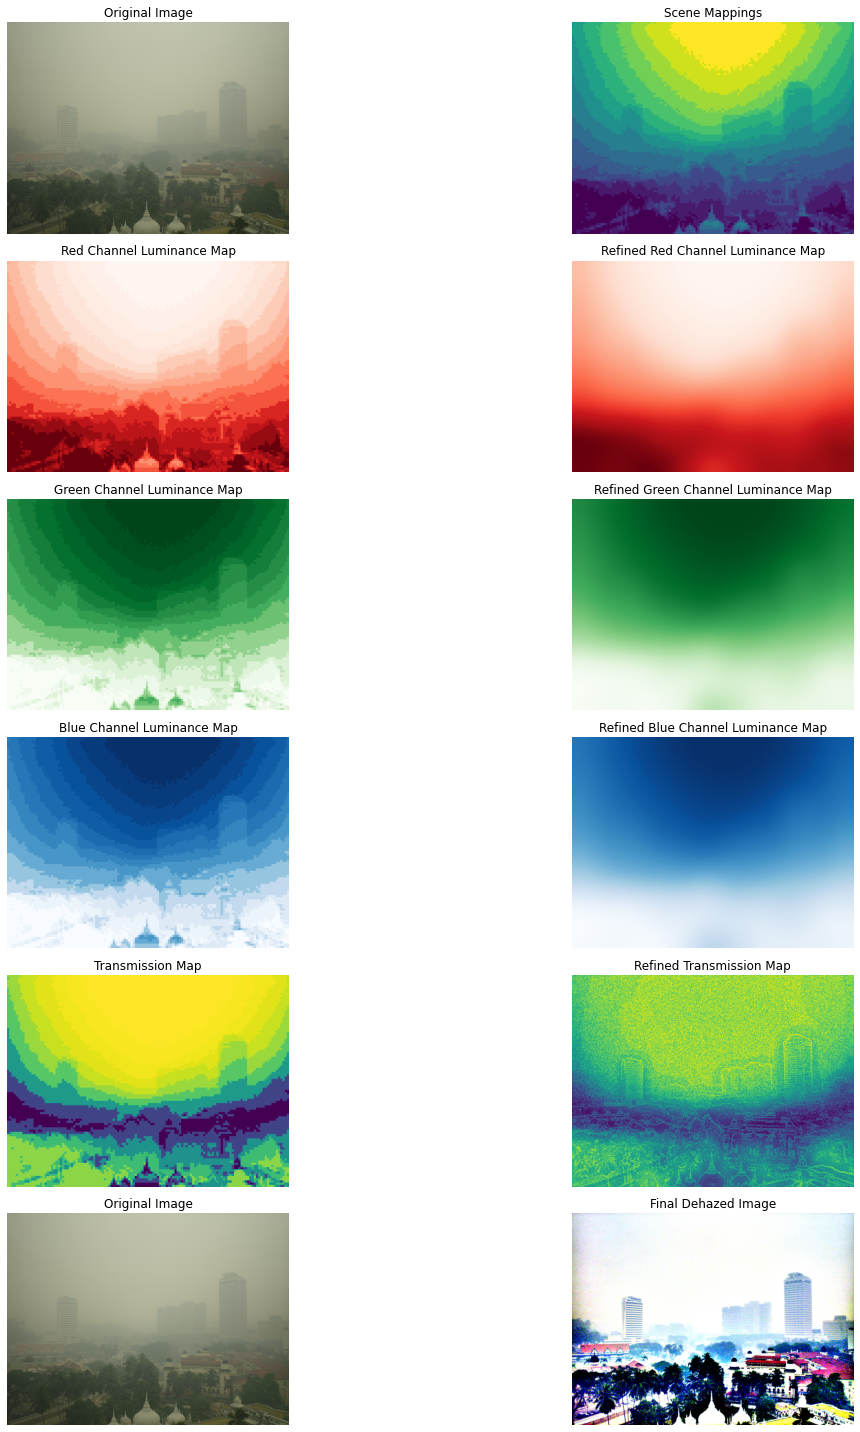

In [9]:
dehaze_image('i1.jpg', k = 15, eps=1e-3, eps2 = 0.1)

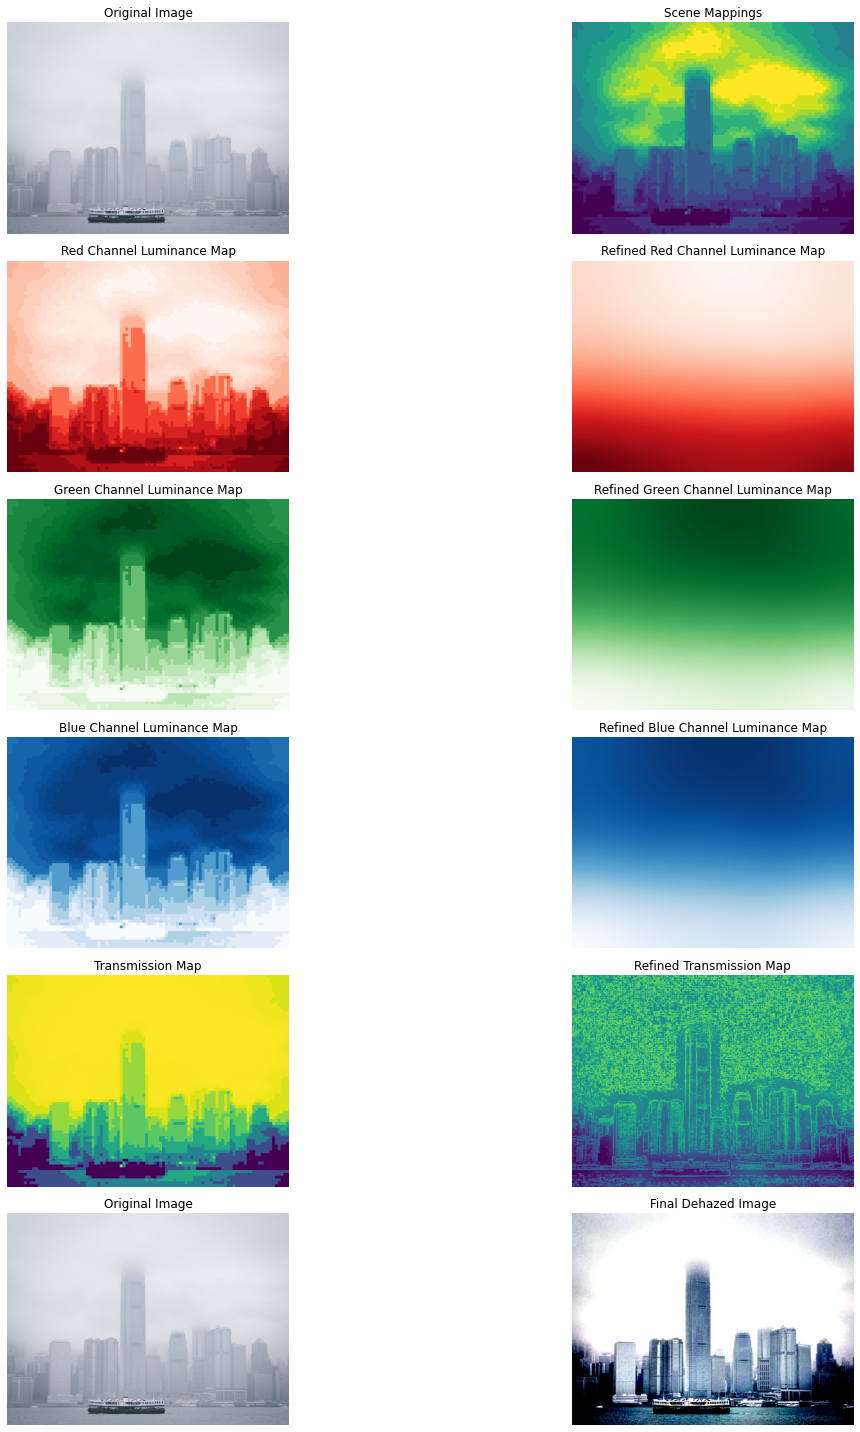

In [10]:
dehaze_image('i2.jpg', k = 15, eps=1e-3, eps2 = 0.01)

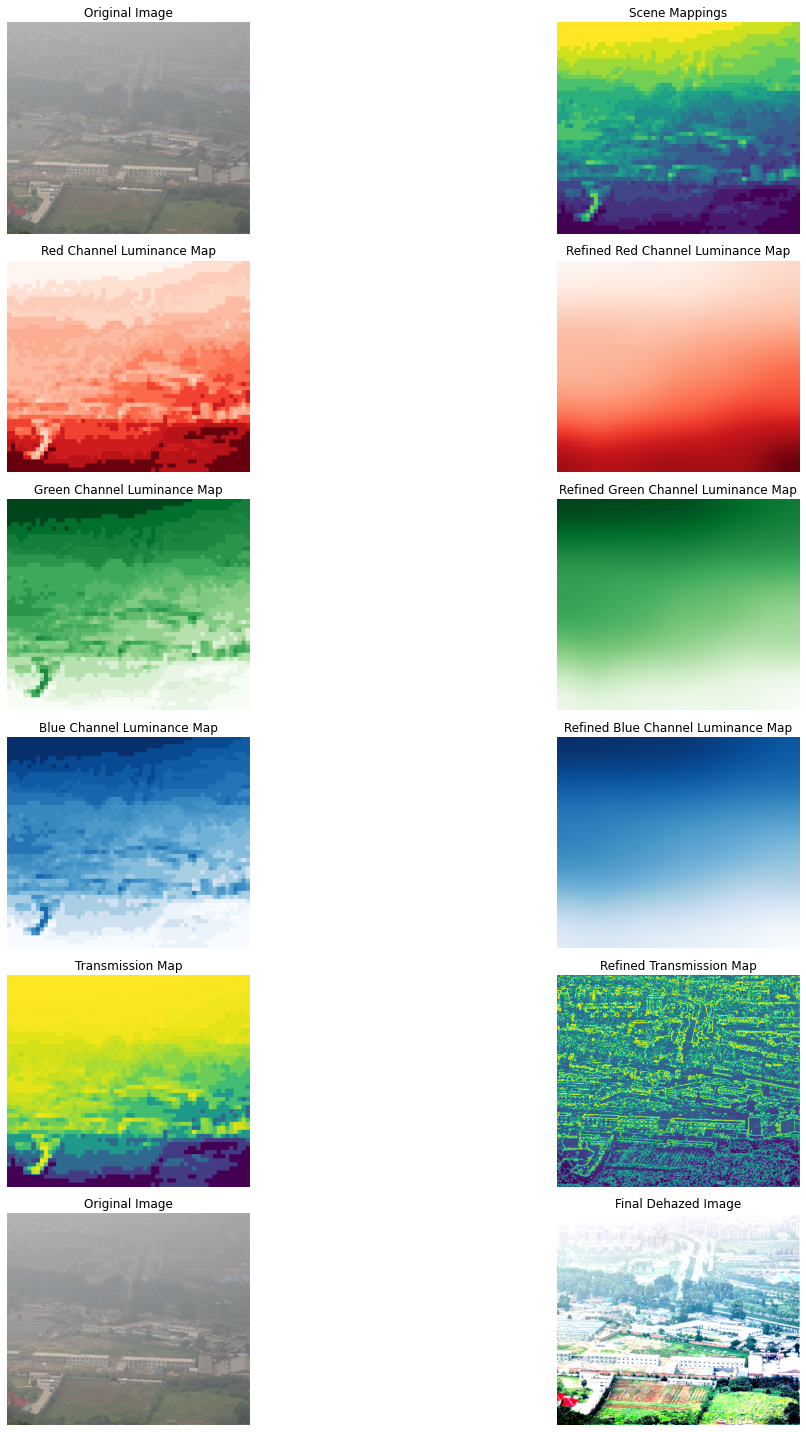

In [11]:
dehaze_image('i3.bmp', k = 15, eps=0.03, eps2 = 0.01)

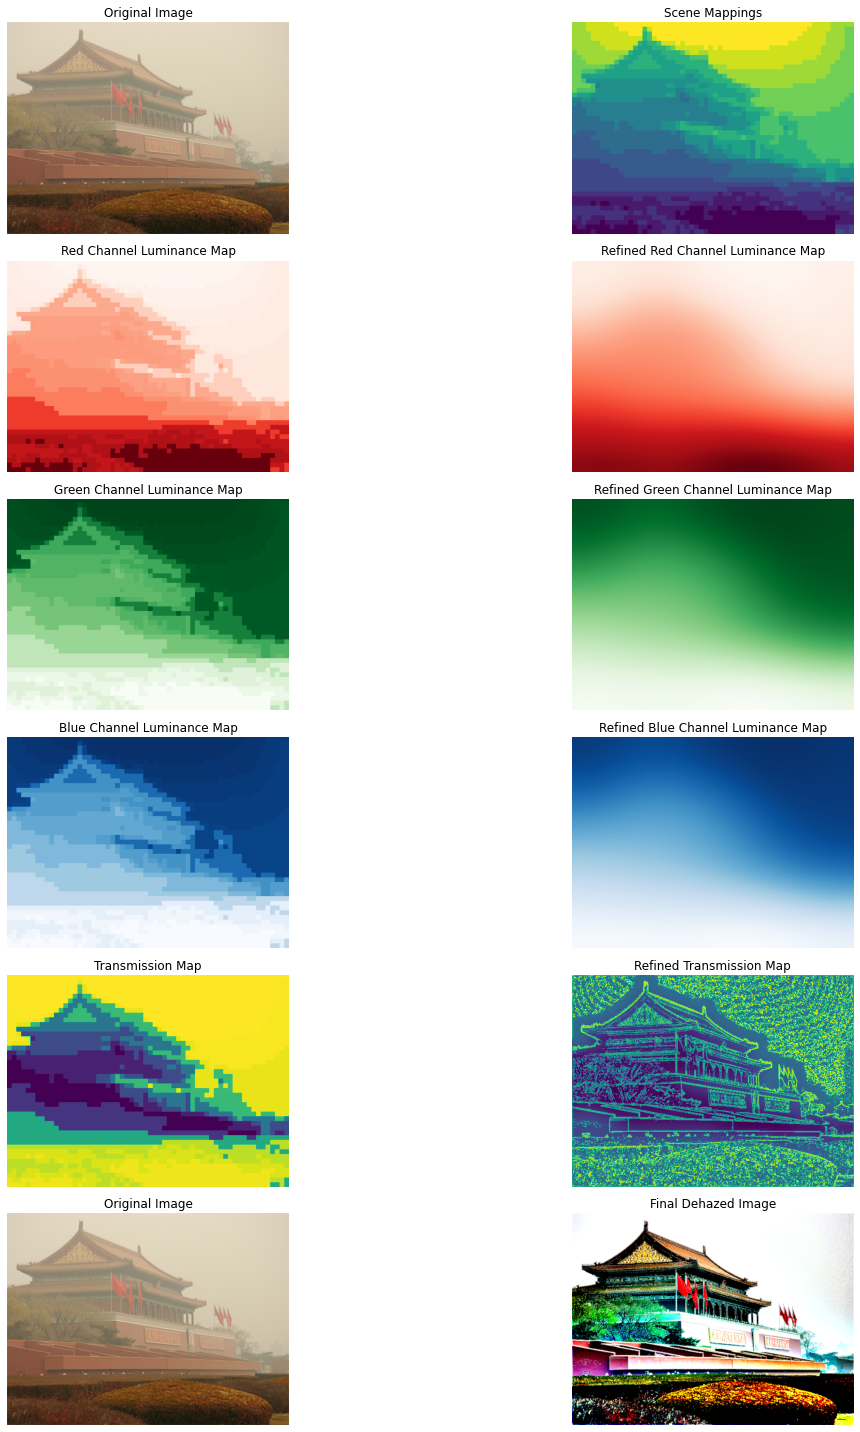

In [12]:
dehaze_image('i4.bmp', k = 15, eps=0.01, eps2 = 0.1)

## Observations:
- 1) The Transmission map values without adjustment were nearly same for all scenes
- 2) The images were dehazed for **different convergence criteria/threshold, which varied from image to image**
- 3) It was observed the images got whiter as the convergence criteria for refinement of transmission map was made stricter, that is as eps was decreased
- 4) It was observed the images got bit dark as the convergence criteria for refinement of luminance map was made stricter, that is as eps2 was decreased
- 5) The obtained results were consistent with the paper